<a href="https://colab.research.google.com/github/meeel29/Analisis-de-datos-/blob/main/Parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# ============================================
# 1. Instalación y configuración inicial
# ============================================

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

### Limpieza y Análisis Exploratorio de Datos (EDA)

In [2]:
# Configuración visual
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (6, 4)

In [3]:
# ============================================
# 2. Carga de datos
# ============================================

mall = pd.read_csv("Mall_Customers.csv")
wholesale = pd.read_csv("Wholesale customers data.csv")

print("Mall shape:", mall.shape)
print("Wholesale shape:", wholesale.shape)

Mall shape: (200, 5)
Wholesale shape: (440, 8)


In [4]:
# ============================================
# 3. Exploración inicial
# ============================================

print("\nPrimeras filas de Mall Customers:")
display(mall.head())

print("\nPrimeras filas de Wholesale Customers:")
display(wholesale.head())



Primeras filas de Mall Customers:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Primeras filas de Wholesale Customers:


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
# ============================================
# 4. Revisión de valores nulos y duplicados
# ============================================

print("Valores nulos en Mall Customers:")
print(mall.isnull().sum(), "\n")
print("Duplicados:", mall.duplicated().sum(), "\n")

print("Valores nulos en Wholesale Customers:")
print(wholesale.isnull().sum(), "\n")
print("Duplicados:", wholesale.duplicated().sum(), "\n")


Valores nulos en Mall Customers:
CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64 

Duplicados: 0 

Valores nulos en Wholesale Customers:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64 

Duplicados: 0 



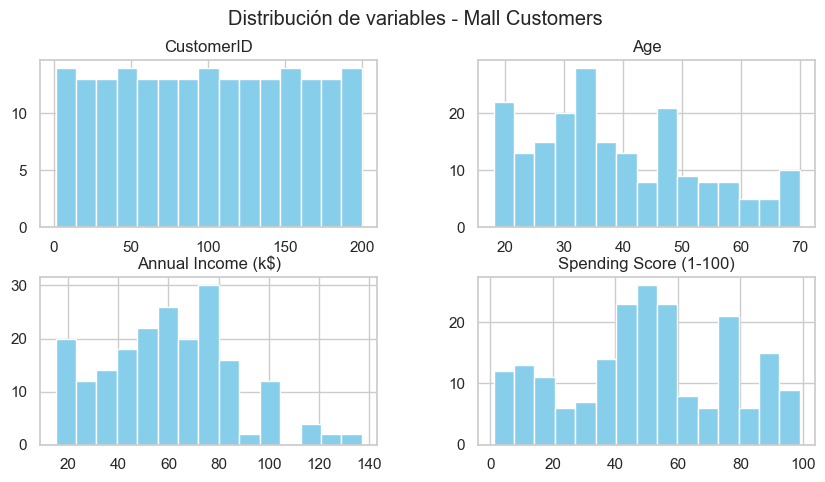

In [6]:
# ============================================
# 5. Exploración visual
# ============================================

# Histogramas Mall
mall.hist(bins=15, figsize=(10, 5), color='skyblue')
plt.suptitle("Distribución de variables - Mall Customers")
plt.show()

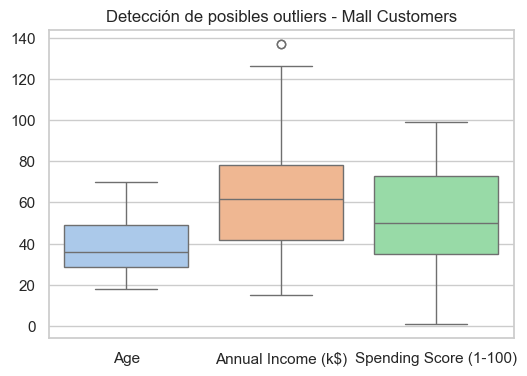

In [7]:
# Boxplots Mall
sns.boxplot(data=mall[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.title("Detección de posibles outliers - Mall Customers")
plt.show()

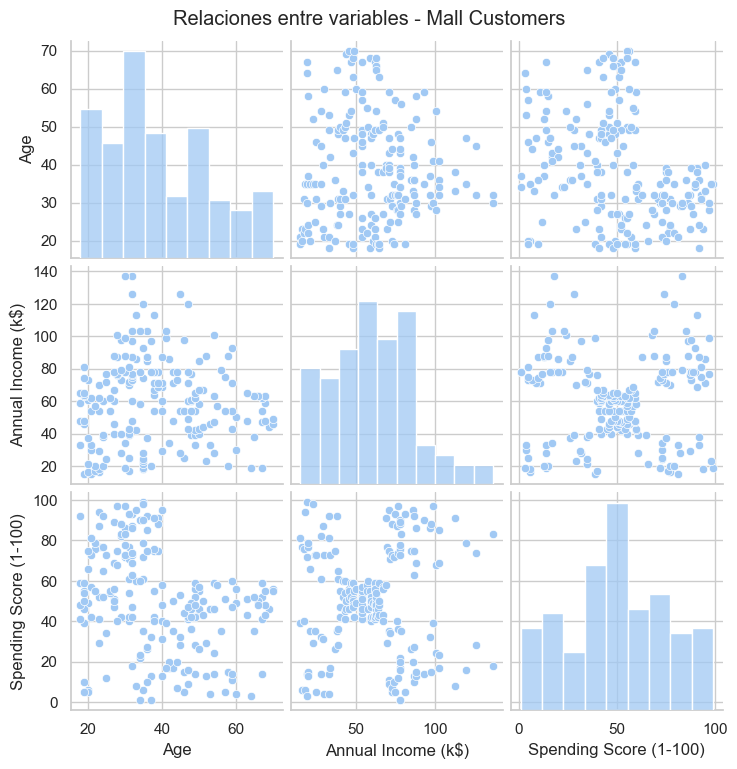

In [8]:
# Pairplot Mall
sns.pairplot(mall[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.suptitle("Relaciones entre variables - Mall Customers", y=1.02)
plt.show()

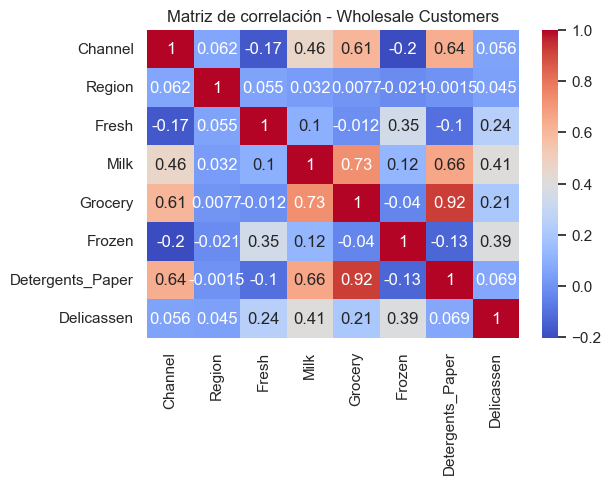

In [9]:
# Correlación Wholesale
sns.heatmap(wholesale.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación - Wholesale Customers")
plt.show()

In [10]:
# ============================================
# 6. Normalización / estandarización
# ============================================

scaler = StandardScaler()

# Mall Customers: solo variables numéricas relevantes
mall_scaled = mall.copy()
mall_scaled[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(
    mall[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
)

# Wholesale Customers: excluye columnas categóricas
wholesale_scaled = wholesale.copy()
wholesale_scaled.iloc[:, 2:] = scaler.fit_transform(wholesale.iloc[:, 2:])

In [11]:
# ============================================
# 7. Guardar datasets limpios
# ============================================

os.makedirs("data", exist_ok=True)
mall_scaled.to_csv("data/mall_clean.csv", index=False)
wholesale_scaled.to_csv("data/wholesale_clean.csv", index=False)

print("Archivos guardados en carpeta /data")

Archivos guardados en carpeta /data


In [12]:
# ============================================
# 8. Resumen final
# ============================================

print("Mall Customers (después de limpieza):", mall_scaled.shape)
print("Wholesale Customers (después de limpieza):", wholesale_scaled.shape)

mall_scaled.describe()

Mall Customers (después de limpieza): (200, 5)
Wholesale Customers (después de limpieza): (440, 8)


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,2.000000e+02,2.000000e+02,2.000000e+02
mean,100.500000,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,57.879185,1.002509e+00,1.002509e+00,1.002509e+00
min,1.000000,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,50.750000,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,100.500000,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,150.250000,7.284319e-01,6.656748e-01,8.851316e-01
max,200.000000,2.235532e+00,2.917671e+00,1.894492e+00


### Clustering - KMeans, DBSCAN y Jerárquico

#### mall_customers.csv

In [13]:
# ============================================
# 1. Importar los datos limpios
# ============================================

mall = pd.read_csv("data/mall_clean.csv")

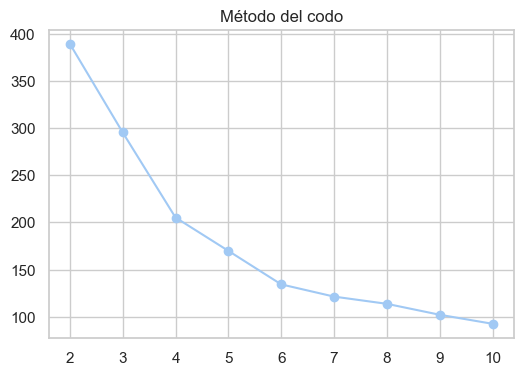

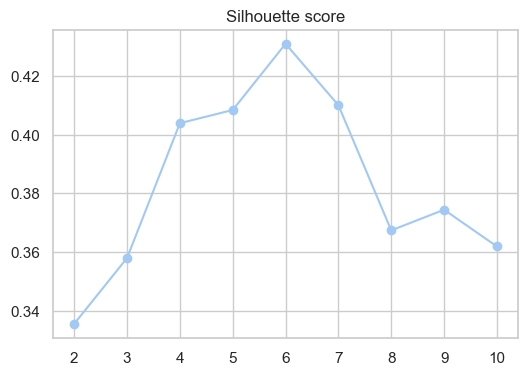

In [14]:
# ============================================
# 2. KMeans - Metodo del codo y Silhouette Score
# ============================================

inertias, silhouettes = [], []
X = mall[['Age','Annual Income (k$)','Spending Score (1-100)']]

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

plt.plot(range(2,11), inertias, marker='o'); plt.title("Método del codo"); plt.show()
plt.plot(range(2,11), silhouettes, marker='o'); plt.title("Silhouette score"); plt.show()


In [15]:
# ============================================
# 3. KMeans - Clustering con valor óptimo de k
# ============================================

kmeans = KMeans(n_clusters=6, random_state=42)
mall['Cluster_KMeans'] = kmeans.fit_predict(X)

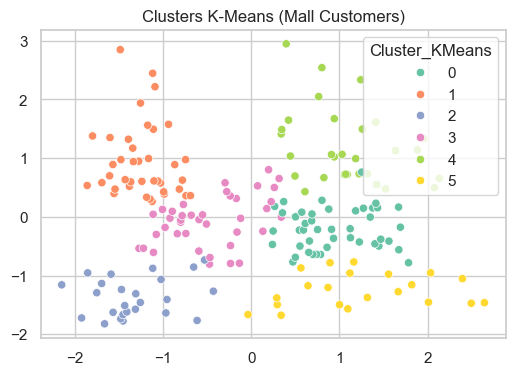

In [16]:
# ============================================
# 4. KMeans - Visualiza con PCA
# ============================================

pca = PCA(n_components=2)
mall_pca = pca.fit_transform(X)
sns.scatterplot(x=mall_pca[:,0], y=mall_pca[:,1], hue=mall['Cluster_KMeans'], palette="Set2")
plt.title("Clusters K-Means (Mall Customers)")
plt.show()

In [17]:
mall.groupby('Cluster_KMeans')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(1)

,Age,Annual Income (k$),Spending Score (1-100)
Cluster_KMeans,,,
0,1.3,-0.2,-0.0
1,-0.4,1.0,1.2
2,-1.0,-1.3,1.0
3,-0.9,-0.0,-0.2
4,0.4,1.1,-1.3
5,0.5,-1.3,-1.2


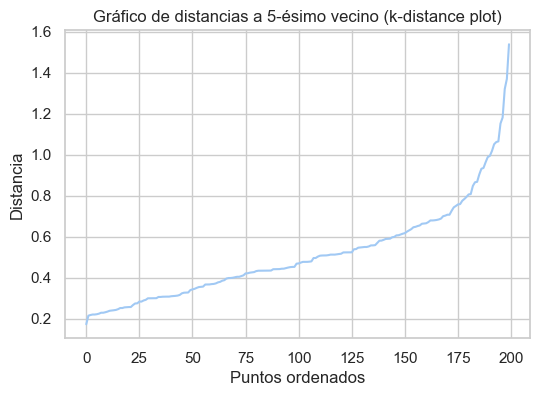

In [18]:
# ============================================
# 5. DBSCAN - Metodo del codo
# ============================================

X = mall[['Age','Annual Income (k$)','Spending Score (1-100)']]
k = 5 

nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)

distances, indices = nn.kneighbors(X)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.title(f"Gráfico de distancias a {k}-ésimo vecino (k-distance plot)")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia")
plt.grid(True)
plt.show()

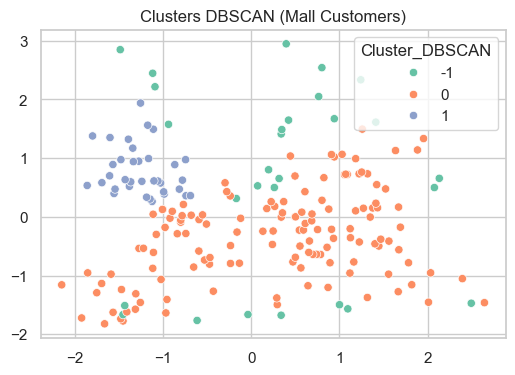

In [19]:
# ============================================
# 6. DBSCAN - Clustering con valor óptimo de k
# ============================================

dbscan = DBSCAN(eps=0.6, min_samples=5)
mall['Cluster_DBSCAN'] = dbscan.fit_predict(X)
sns.scatterplot(x=mall_pca[:,0], y=mall_pca[:,1], hue=mall['Cluster_DBSCAN'], palette="Set2")
plt.title("Clusters DBSCAN (Mall Customers)")
plt.show()

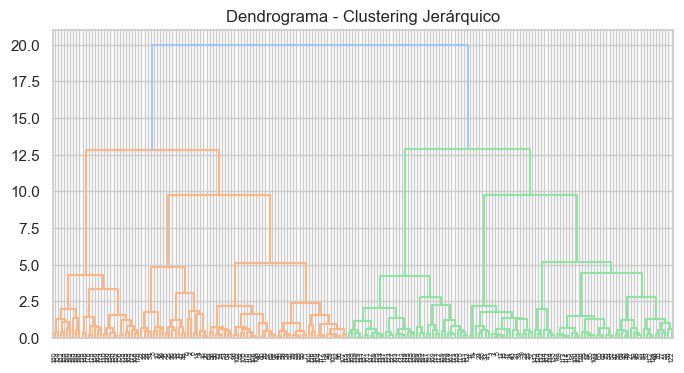

In [20]:
# ============================================
# 7. Jerárquico - Metodo de dendrograma
# ============================================

linked = linkage(X, method='ward')
plt.figure(figsize=(8,4))
dendrogram(linked)
plt.title("Dendrograma - Clustering Jerárquico")
plt.show()

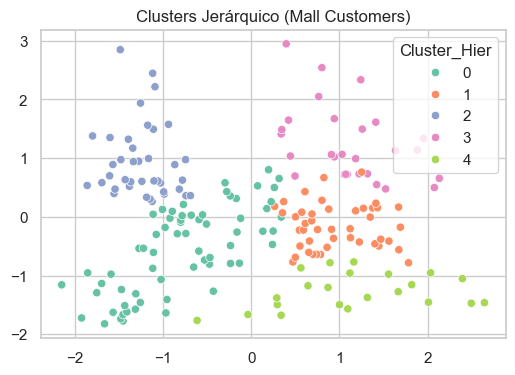

In [21]:
# ============================================
# 8. Jerárquico - Clustering con valor óptimo de k
# ============================================

hier = AgglomerativeClustering(n_clusters=5)
mall['Cluster_Hier'] = hier.fit_predict(X)

sns.scatterplot(x=mall_pca[:,0], y=mall_pca[:,1], hue=mall['Cluster_Hier'], palette="Set2")
plt.title("Clusters Jerárquico (Mall Customers)")
plt.show()

In [22]:
# ============================================
# 9. Comparar los resultados
# ============================================

resumen = {
    "KMeans": mall['Cluster_KMeans'].value_counts().sort_index(),
    "DBSCAN": mall['Cluster_DBSCAN'].value_counts().sort_index(),
    "Jerárquico": mall['Cluster_Hier'].value_counts().sort_index()
}

tabla_clusters = pd.DataFrame(resumen).fillna(0).astype(int)

print("Distribución de clientes por cluster\n")
display(tabla_clusters)

Distribución de clientes por cluster



,KMeans,DBSCAN,Jerárquico
-1,0,28,0
0,45,137,66
1,39,35,45
2,25,0,39
3,40,0,28
4,30,0,22
5,21,0,0


In [23]:
# ============================================
# 10. Guardar resultados
# ============================================

mallOriginal = pd.read_csv("Mall_Customers.csv")
mallOriginal['Cluster_KMeans'] = mall['Cluster_KMeans']
mallOriginal['Cluster_DBSCAN'] = mall['Cluster_DBSCAN']
mallOriginal['Cluster_Hier'] = mall['Cluster_Hier']
mallOriginal.to_csv("data/mall_clusters.csv", index=False)

In [24]:
# ============================================
# 11. Análisis de negocio de clusters
# ============================================

display(mallOriginal.groupby('Cluster_KMeans')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(1))

display(mallOriginal.groupby('Cluster_DBSCAN')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(1))

display(mallOriginal.groupby('Cluster_Hier')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(1))


,Age,Annual Income (k$),Spending Score (1-100)
Cluster_KMeans,,,
0,56.3,54.3,49.1
1,32.7,86.5,82.1
2,25.6,26.5,76.2
3,26.1,59.4,44.4
4,44.0,90.1,17.9
5,45.5,26.3,19.4


,Age,Annual Income (k$),Spending Score (1-100)
Cluster_DBSCAN,,,
-1,36.1,76.9,33.2
0,41.0,51.6,45.3
1,32.7,82.5,82.8


,Age,Annual Income (k$),Spending Score (1-100)
Cluster_Hier,,,
0,26.6,47.4,56.8
1,56.4,55.3,48.4
2,32.7,86.5,82.1
3,43.9,91.3,16.7
4,44.3,25.8,20.3


#### wholesale_customers.csv

In [25]:
# ============================================
# 1. Importar los datos limpios
# ============================================

wholesale = pd.read_csv("data/wholesale_clean.csv")

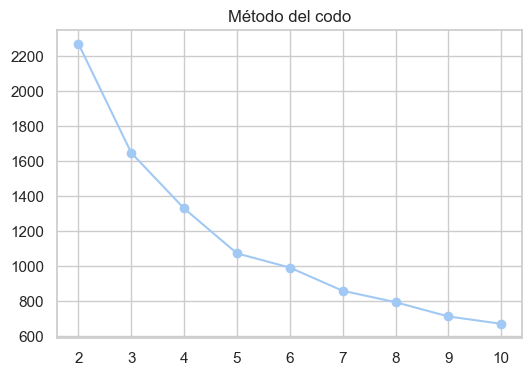

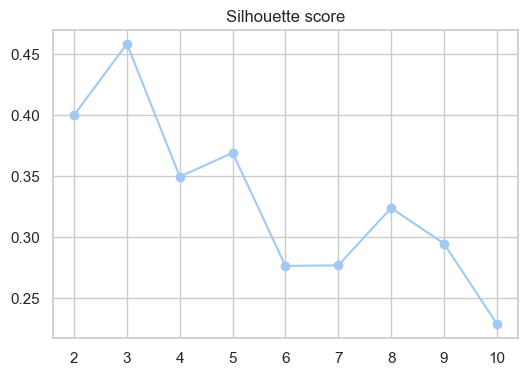

In [26]:
# ============================================
# 2. KMeans - Metodo del codo y Silhouette Score
# ============================================

inertias, silhouettes = [], []
X = wholesale.drop(['Channel', 'Region'], axis=1)

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

plt.plot(range(2,11), inertias, marker='o'); plt.title("Método del codo"); plt.show()
plt.plot(range(2,11), silhouettes, marker='o'); plt.title("Silhouette score"); plt.show()


In [27]:
# ============================================
# 3. KMeans - Clustering con valor óptimo de k
# ============================================

kmeans = KMeans(n_clusters=3, random_state=42)
wholesale['Cluster_KMeans'] = kmeans.fit_predict(X)

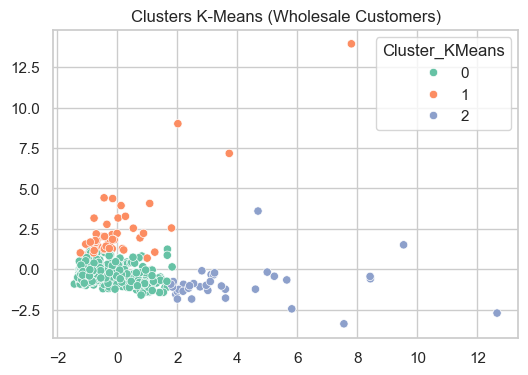

In [28]:
# ============================================
# 4. KMeans - Visualiza con PCA
# ============================================

pca = PCA(n_components=2)
wholesale_pca = pca.fit_transform(X)
sns.scatterplot(x=wholesale_pca[:,0], y=wholesale_pca[:,1], hue=wholesale['Cluster_KMeans'], palette="Set2")
plt.title("Clusters K-Means (Wholesale Customers)")
plt.show()

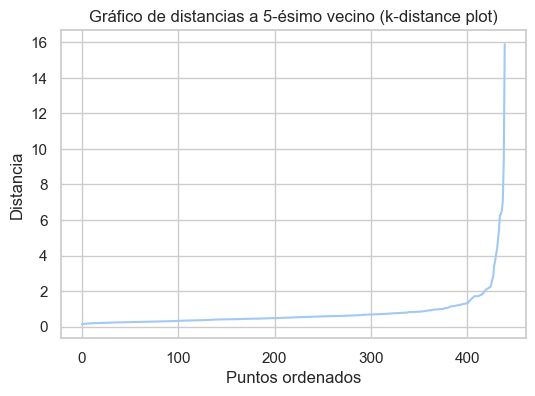

In [29]:
# ============================================
# 5. DBSCAN - Metodo del codo
# ============================================

X = wholesale[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']]
k = 5 

nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)

distances, indices = nn.kneighbors(X)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.title(f"Gráfico de distancias a {k}-ésimo vecino (k-distance plot)")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia")
plt.grid(True)
plt.show()

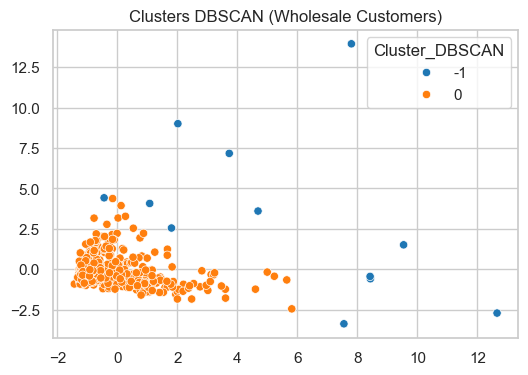

In [30]:
# ============================================
# 6. DBSCAN - Clustering con valor óptimo de k
# ============================================

dbscan = DBSCAN(eps=3, min_samples=5)
wholesale['Cluster_DBSCAN'] = dbscan.fit_predict(X)
sns.scatterplot(x=wholesale_pca[:,0], y=wholesale_pca[:,1], hue=wholesale['Cluster_DBSCAN'], palette="tab10")
plt.title("Clusters DBSCAN (Wholesale Customers)")
plt.show()

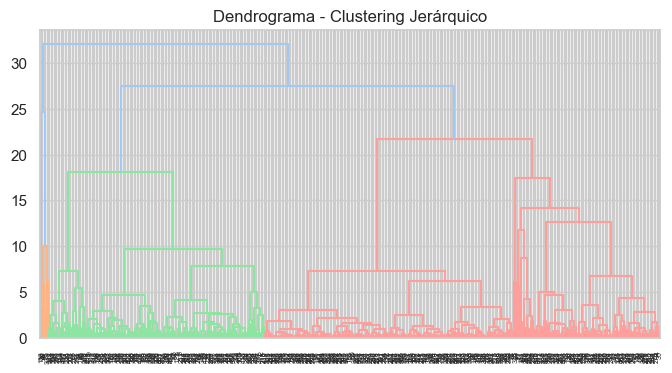

In [31]:
# ============================================
# 7. Jerárquico - Metodo de dendrograma
# ============================================

linked = linkage(X, method='ward')
plt.figure(figsize=(8,4))
dendrogram(linked)
plt.title("Dendrograma - Clustering Jerárquico")
plt.show()

hier = AgglomerativeClustering(n_clusters=5)
wholesale['Cluster_Hier'] = hier.fit_predict(X)

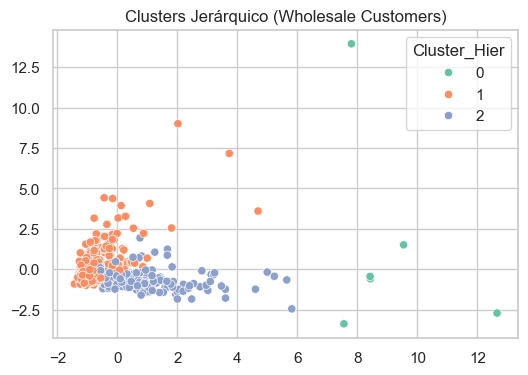

In [32]:
# ============================================
# 8. Jerárquico - Clustering con valor óptimo de k
# ============================================

hier = AgglomerativeClustering(n_clusters=3)
wholesale['Cluster_Hier'] = hier.fit_predict(X)

sns.scatterplot(x=wholesale_pca[:,0], y=wholesale_pca[:,1], hue=wholesale['Cluster_Hier'], palette="Set2")
plt.title("Clusters Jerárquico (Wholesale Customers)")
plt.show()

In [33]:
# ============================================
# 9. Comparar los resultados
# ============================================

resumen = {
    "KMeans": wholesale['Cluster_KMeans'].value_counts().sort_index(),
    "DBSCAN": wholesale['Cluster_DBSCAN'].value_counts().sort_index(),
    "Jerárquico": wholesale['Cluster_Hier'].value_counts().sort_index()
}

tabla_clusters = pd.DataFrame(resumen).fillna(0).astype(int)

print("Distribución de clientes por cluster\n")
display(tabla_clusters)

Distribución de clientes por cluster



,KMeans,DBSCAN,Jerárquico
-1,0,12,0
0,350,428,6
1,53,0,281
2,37,0,153


In [34]:

# ============================================
# 10. Guardar resultados
# ============================================

wholesaleOriginal = pd.read_csv("Wholesale customers data.csv")
wholesaleOriginal['Cluster_KMeans'] = wholesale['Cluster_KMeans']
wholesaleOriginal['Cluster_DBSCAN'] = wholesale['Cluster_DBSCAN']
wholesaleOriginal['Cluster_Hier'] = wholesale['Cluster_Hier']
wholesaleOriginal.to_csv("data/wholesale_clusters.csv", index=False)

In [35]:
# ============================================
# 11. Análisis de negocio de clusters
# ============================================


display(wholesaleOriginal.groupby('Cluster_KMeans')[['Channel', 'Region', 'Fresh', 'Milk','Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].mean().round(1))

display(wholesaleOriginal.groupby('Cluster_DBSCAN')[['Channel', 'Region', 'Fresh', 'Milk','Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].mean().round(1))


display(wholesaleOriginal.groupby('Cluster_Hier')[['Channel', 'Region', 'Fresh', 'Milk','Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].mean().round(1))

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster_KMeans,,,,,,,,
0,1.3,2.5,8935.5,4228.5,5848.0,2167.2,1913.6,1102.1
1,1.1,2.7,34540.1,5860.4,6122.6,9841.7,981.5,3664.2
2,2.0,2.4,8704.9,20534.4,30466.2,1932.6,14758.8,2459.4


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster_DBSCAN,,,,,,,,
-1,1.5,2.8,34081.1,29455.7,34378.8,14931.3,13874.2,10307.5
0,1.3,2.5,11381.2,5132.9,7210.3,2739.4,2573.3,1278.6


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster_Hier,,,,,,,,
0,1.8,2.8,27477.0,43542.2,54588.5,8285.7,25018.3,10247.8
1,1.1,2.5,15048.9,3017.3,3791.8,3837.3,758.0,1309.9
2,1.7,2.5,5794.2,9419.9,13761.7,1461.8,5913.4,1577.6
